In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [14]:
"""
Generate an \tilde{A} through the method outlined in the 'Operator Learning without the Adjoint' paper,
defining it to be \epsilon near symmetric, and then comparing that with the \tilde{\epsilon} definition
we had used in our own research.
"""

n = 100
r = 10
rng = np.random.default_rng(123)

G = np.random.rand(n,r)

U_A, _ = np.linalg.qr(G)

pert_size = np.linspace(0, 0.4, 1000)

epsilon = 0.05
epsilon_2 = epsilon / 2

matrices = []
good_matrices = []

for i, pert in enumerate(pert_size):

    S = rng.standard_normal((r,r))

    S = 0.5 * (S - S.T)

    S /= np.linalg.norm(S)

    Q = linalg.expm(pert * S)

    V_A, _ = np.linalg.qr(U_A @ Q)

    matrices.append(V_A)

for k,matrix in enumerate(matrices):

    svd = np.linalg.svd(U_A.T @ matrix, compute_uv=False)
    smallest_sing_val = svd[-1]

    if (1 - smallest_sing_val <= epsilon) and (1 - smallest_sing_val > epsilon_2):
        good_matrices.append(matrix)


print("Number of viable matrices: ",len(good_matrices))








<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\aleks\AppData\Local\Temp\ipykernel_49156\4162844457.py:1: SyntaxWarning: invalid escape sequence '\e'
  """


Number of viable matrices:  0


In [15]:
import numpy as np
from scipy import linalg

# -------- parameters -------------------------------------------------
n, r   = 100, 10
rng    = np.random.default_rng(123)

pert_size   = np.linspace(0.0, 0.4, 1000)   # rotation angle ε
lower, upper = 0.95, 0.975                  # target σ_min window
# --------------------------------------------------------------------

# --- orthonormal U_A -------------------------------------------------
U_A, _ = np.linalg.qr(rng.standard_normal((n, r)))

good_matrices = []

for eps in pert_size:
    # random skew-symmetric S with ‖S‖₂ = 1
    S = rng.standard_normal((r, r))         # ← shape tuple
    S = 0.5 * (S - S.T)
    S /= np.linalg.norm(S, 2)

    Q = linalg.expm(eps * S)                # exp(ε S) ≈ I + εS
    V_A, _ = np.linalg.qr(U_A @ Q)          # keep columns orthonormal

    sigma_min = np.linalg.svd(U_A.T @ V_A, compute_uv=False)[-1]
    if lower <= sigma_min < upper:
        good_matrices.append(V_A)

print("Number of viable matrices:", len(good_matrices))

Number of viable matrices: 0


In [1]:
import numpy as np
from scipy.linalg import qr

n, r = 100, 10
rng = np.random.default_rng(123)

# fixed orthonormal U_A
U_A, _ = qr(rng.standard_normal((n, r)), mode='economic')

target_lo, target_hi = 0.95, 0.975          # sigma_min window
eps_grid            = np.linspace(0, 0.20, 500)

good_matrices = []
epsilons = []

for eps in eps_grid:
    # random noise in the orthogonal complement of U_A
    E = rng.standard_normal((n, r))
    E = E - U_A @ (U_A.T @ E)               # make E perp to span(U_A)
    V_candidate = U_A + eps * E             # epsilon–perturbation
    V_A, _ = qr(V_candidate, mode='economic')

    sigma_min = np.linalg.svd(U_A.T @ V_A, compute_uv=False)[-1]
    if target_lo <= sigma_min < target_hi:
        good_matrices.append(V_A)
        epsilons.append(1 - sigma_min)
        

print("Number of viable matrices:", len(good_matrices))

Number of viable matrices: 22


In [3]:
sing_vals_A = [1e-7, 1e-7, 1e-7, 1e-2, 1e-2, 1e-2, 1e-1, 1, 1, 1]
sing_vals_A = sing_vals_A[::-1]

tilde_eps = []

for k, good_matrix in enumerate(good_matrices):

    A = U_A @ np.diag(sing_vals_A) @ good_matrix.T # made an \epsilon near symmetric matrix

    epsilon_tilde = A - A.T

    our_symmetry = np.linalg.norm(epsilon_tilde)

    tilde_eps.append(our_symmetry)

fig, ax = plt.subplots(figsize=(6, 5))

ax.loglog(epsilons, tilde_eps, 'o', markersize=6,
          markerfacecolor='tab:blue', markeredgecolor='k', alpha=0.85)

ax.set_xlabel(r'$\varepsilon \;=\; 1-\sigma_{\min}(U_A^{\!*}V_A)$', fontsize=12)
ax.set_ylabel(r'$\tilde{\varepsilon} \;=\;\|A-A^\top\|_2$', fontsize=12)
ax.set_title('Comparison of near-symmetry measures', fontsize=14)
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()    




NameError: name 'plt' is not defined

band [0.988, 0.99) produced 0 samples


C:\Users\aleks\AppData\Local\Temp\ipykernel_28296\2055844873.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


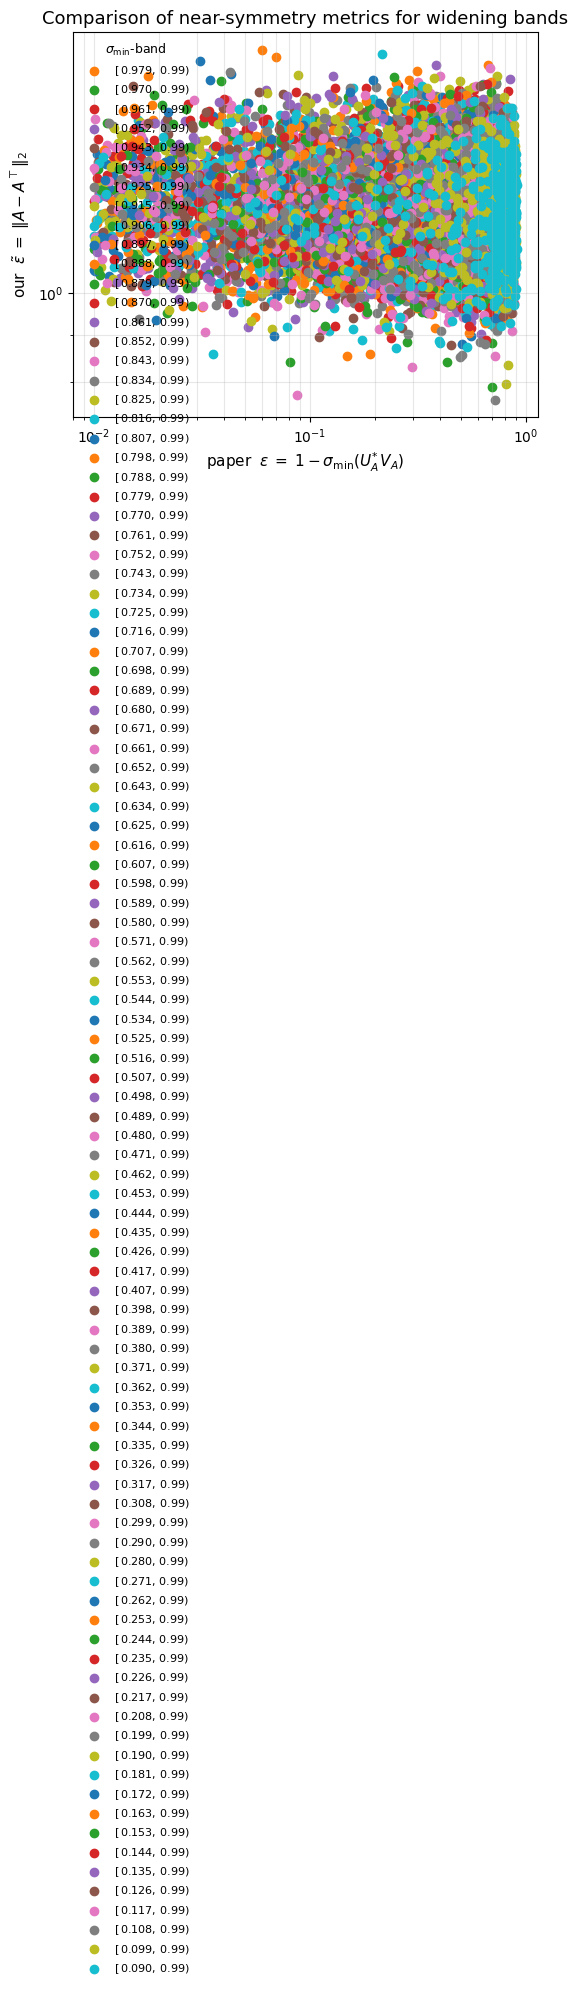

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr, svd, norm, expm

# --------------------------------------------------
# 0.  Fixed data  (same as before)
# --------------------------------------------------
n, r   = 100, 10
rng    = np.random.default_rng(123)
U_A, _ = qr(rng.standard_normal((n, r)), mode="economic")

# singular values for Σ
sing_vals_A = [1e-7, 1e-7, 1e-7, 1e-2, 1e-2, 1e-2, 1e-1, 1, 1, 1][::-1]
Σ = np.diag(sing_vals_A)

# grid of perturbation magnitudes for generating V_A
eps_grid = np.linspace(0.0, 0.25, 600)

# --------------------------------------------------
# 1.  Define the widening windows
#    upper = 0.99  ;  lower moves from 0.99-Δ down to 0.90
# --------------------------------------------------
upper_sigma = 0.99
deltas      = np.linspace(2e-3, 9e-1, 100)

# plotting setup
fig, ax = plt.subplots(figsize=(6, 5))
cmap    = plt.get_cmap("tab10")

for j, Δ in enumerate(deltas):
    lower_sigma = upper_sigma - Δ
    colour      = cmap(j % 10)

    eps_paper   = []      # ε  from the paper
    tilde_eps   = []      # ~ε  our measure

    for eps in eps_grid:
        # -- random V_A close to U_A -----------------------------------
        S = rng.standard_normal((r, r))
        S = 0.5 * (S - S.T)
        S /= norm(S, 2)
        Q     = expm(eps * S)
        V_A, _ = qr(U_A + eps * rng.standard_normal((n, r)) - U_A @ (U_A.T @ rng.standard_normal((n, r))),
                    mode="economic")

        sigma_min = svd(U_A.T @ V_A, compute_uv=False)[-1]
        if lower_sigma <= sigma_min < upper_sigma:
            eps_paper.append(1.0 - sigma_min)

            A = U_A @ Σ @ V_A.T
            tilde_eps.append(norm(A - A.T, 2))

    if eps_paper:                       # skip empty bands
        ax.scatter(eps_paper, tilde_eps,
                   color=colour, label=fr"$[\,{lower_sigma:.3f},\,0.99)$")
    else:
        print(f"band [{lower_sigma:.3f}, 0.99) produced 0 samples")

# --------------------------------------------------
# 2.  aesthetics
# --------------------------------------------------
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"paper $\;\varepsilon \;=\; 1-\sigma_{\min}(U_A^{\!*}V_A)$",
              fontsize=11)
ax.set_ylabel(r"our $\;\tilde{\varepsilon} \;=\; \|A-A^{\top}\|_2$",
              fontsize=11)
ax.set_title("Comparison of near-symmetry metrics for widening bands",
             fontsize=13)
ax.grid(True, which='both', alpha=0.3)
ax.legend(title=r"$\sigma_{\min}$-band", fontsize=8, title_fontsize=9,
          loc="upper left", frameon=False)

plt.tight_layout()
plt.show()


Average gradient for paper ε: 1.971
Average gradient for tilde ε: 0.676


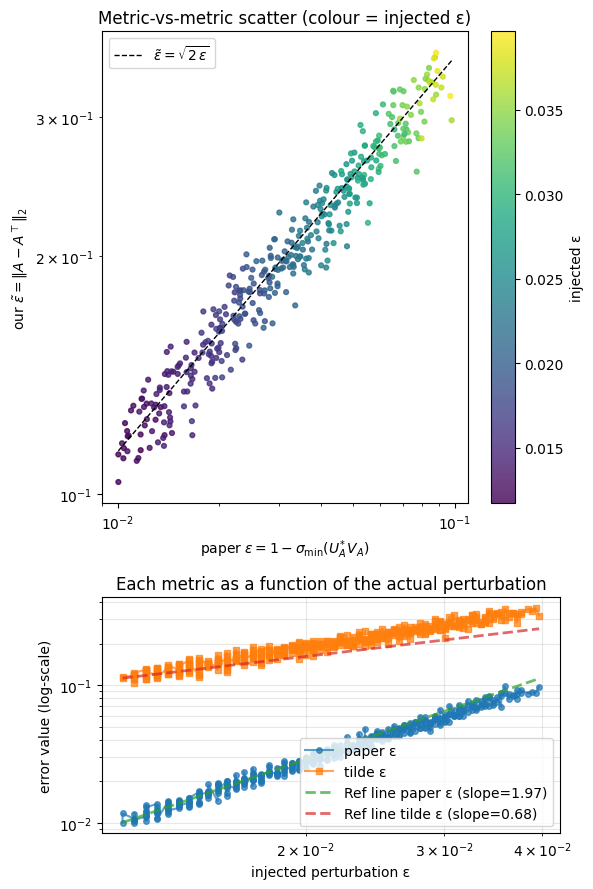

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr, svd, norm, expm

# -------- 1. fixed data  -------------------------------------------------
n, r   = 100, 10
rng    = np.random.default_rng(123)
U_A, _ = qr(rng.standard_normal((n, r)), mode="economic")

Σ = np.diag([1e2, 1e1, 1, .1, .01, .01, .01, 1e-7, 1e-7, 1e-7][::-1])

eps_grid     = np.linspace(0.0, 0.25, 600)          # injected ε
upper_sigma  = 0.99
deltas       = np.linspace(2e-4, 9e-2, 10)          # widening windows

# containers for ALL points
all_eps_paper, all_tilde, all_eps_injected = [], [], []

for Δ in deltas:
    lower_sigma = upper_sigma - Δ
    for eps in eps_grid:
        # V_A generation (same idea as before)
        S = rng.standard_normal((r, r))
        S = 0.5 * (S - S.T) / norm(S, 2)
        noise  = rng.standard_normal((n, r))
        noise -= U_A @ (U_A.T @ noise)
        V_A, _ = qr(U_A + eps * noise, mode="economic")

        sigma_min = svd(U_A.T @ V_A, compute_uv=False)[-1]
        if lower_sigma <= sigma_min < upper_sigma:
            A = U_A @ Σ @ V_A.T
            A /= norm(A,2)
            all_eps_paper.append(1.0 - sigma_min)
            all_tilde.append(norm(A - A.T, 2))
            all_eps_injected.append(eps)

# convert to arrays for easy plotting / sorting
all_eps_paper     = np.array(all_eps_paper)
all_tilde         = np.array(all_tilde)
all_eps_injected  = np.array(all_eps_injected)

# -------------------------------------------------------------------------
# 2.  PLOT
# -------------------------------------------------------------------------
fig, (ax_scatter, ax_curves) = plt.subplots(2, 1, figsize=(6, 9),
                                            gridspec_kw={'height_ratios':[2,1]})

# -- (a) original scatter
sc = ax_scatter.scatter(all_eps_paper, all_tilde, c=all_eps_injected,
                        cmap='viridis', s=12, alpha=0.8)
# after drawing the scatter 'sc'…
x = np.array([all_eps_paper.min(), all_eps_paper.max()])
ax_scatter.plot(x, 0.8 * np.sqrt(2*x), 'k--', lw=1,
                label=r'$\tilde{\varepsilon} = \sqrt{2\,\varepsilon}$')
ax_scatter.legend()
ax_scatter.set_xscale('log')
ax_scatter.set_yscale('log')
ax_scatter.set_xlabel(r"paper $\varepsilon = 1-\sigma_{\min}(U_A^{\!*}V_A)$")
ax_scatter.set_ylabel(r"our $\tilde{\varepsilon} = \|A-A^{\top}\|_2$")
ax_scatter.set_title("Metric-vs-metric scatter (colour = injected ε)")
fig.colorbar(sc, ax=ax_scatter, label="injected ε")

# -- (b) both metrics as functions of injected ε
# sort by ε so the curve looks nice
idx = np.argsort(all_eps_injected)
ax_curves.loglog(all_eps_injected[idx], all_eps_paper[idx], 'o-', label='paper ε',
                 markersize=4, alpha=0.7)
ax_curves.loglog(all_eps_injected[idx], all_tilde[idx], 's-', label='tilde ε',
                 markersize=4, alpha=0.7)
ax_curves.set_xlabel("injected perturbation ε")
ax_curves.set_ylabel("error value (log-scale)")
ax_curves.set_title("Each metric as a function of the actual perturbation")
ax_curves.grid(True, which='both', alpha=0.3)
ax_curves.legend()

# Remove duplicate x-values and sort
unique_mask = np.concatenate(([True], np.diff(all_eps_injected[idx]) > 1e-12))
eps_unique = all_eps_injected[idx][unique_mask]
paper_unique = all_eps_paper[idx][unique_mask]
tilde_unique = all_tilde[idx][unique_mask]

# Only proceed if we have enough unique points
if len(eps_unique) > 3:
    log_eps_injected = np.log10(eps_unique)
    log_eps_paper = np.log10(paper_unique)
    log_tilde = np.log10(tilde_unique)

    # Calculate gradients using finite differences
    gradient_paper = np.gradient(log_eps_paper, log_eps_injected)
    gradient_tilde = np.gradient(log_tilde, log_eps_injected)

    # Calculate average gradients (excluding NaN/inf values)
    finite_mask_paper = np.isfinite(gradient_paper)
    finite_mask_tilde = np.isfinite(gradient_tilde)
    
    if np.any(finite_mask_paper):
        avg_gradient_paper = np.mean(gradient_paper[finite_mask_paper])
    else:
        avg_gradient_paper = np.nan
        
    if np.any(finite_mask_tilde):
        avg_gradient_tilde = np.mean(gradient_tilde[finite_mask_tilde])
    else:
        avg_gradient_tilde = np.nan

    # Plot reference lines with the calculated slopes
    x_ref = eps_unique
    if np.isfinite(avg_gradient_paper) and abs(avg_gradient_paper) < 100:
        # Create a reference line: y = C * x^slope
        # Use the first data point to determine the constant C
        C_paper = paper_unique[0] / (eps_unique[0] ** avg_gradient_paper)
        y_ref_paper = C_paper * (x_ref ** avg_gradient_paper)
        ax_curves.loglog(x_ref, y_ref_paper, '--', alpha=0.7, linewidth=2, 
                         label=f'Ref line paper ε (slope={avg_gradient_paper:.2f})')

    if np.isfinite(avg_gradient_tilde) and abs(avg_gradient_tilde) < 100:
        # Create a reference line: y = C * x^slope
        C_tilde = tilde_unique[0] / (eps_unique[0] ** avg_gradient_tilde)
        y_ref_tilde = C_tilde * (x_ref ** avg_gradient_tilde)
        ax_curves.loglog(x_ref, y_ref_tilde, '--', alpha=0.7, linewidth=2, 
                         label=f'Ref line tilde ε (slope={avg_gradient_tilde:.2f})')

    # Update legend to include gradient lines
    ax_curves.legend()

    # Print gradient values
    print(f"Average gradient for paper ε: {avg_gradient_paper:.3f}")
    print(f"Average gradient for tilde ε: {avg_gradient_tilde:.3f}")
else:
    print("Not enough unique points for gradient calculation")

plt.tight_layout()
plt.show()

In [9]:
matrix = [[0, -1000], [1000,0]]

exponential_matrix = expm(matrix)

get_sing_val = svd(exponential_matrix, compute_uv= False)[-1]

print(get_sing_val)

1.0000000000096783


In [10]:
import numpy as np
from scipy.linalg import qr, expm, svd

# 2-D toy: n = 2, r = 1
theta = 0.05
U  = np.array([[1.],[0.]])                 # U_A  (n×r)
W  = np.array([[0.],[1.]])                 # W_A  (n×r)

# 2×2 rotation acting on [U W]
R = expm(theta * np.array([[0.,-1.],
                           [1., 0.]]))     # 2×2

V = (np.hstack([U,W]) @ R)[:,0:1]          # first column = V_A

sigma_min = svd(U.T @ V, compute_uv=False)[-1]
print("σ_min(U^T V) =", sigma_min)         # cos θ
print("paper ε      =", 1-sigma_min)       # ≈ ½ θ²

σ_min(U^T V) = 0.9987502603949663
paper ε      = 0.0012497396050337173
